## TEMPERATURE PREDICTION MODEL FOR SLOVENIA

This notebook, when ran, collects weather data from https://meteo.arso.gov.si/ which is the national weather website for Slovenia. It tries to predict the future temperatures for main Slovenian regions. 

MOTIVATION
The project was conceived for a couple of reasons. I aimed to challenge myself in the realm of web scraping, and ARSO proved to be just the right level of complexity given my current skillset. Additionally, I sought to develop a relatively straightforward prediction model and perform elementary data analysis to hone my skills outside of my current job. The final source of motivation was the requirement to create a project for the UVP course at the Faculty of Mathematics and Physics at the University of Ljubljana.

EXTRA FILES
Besides this notebook, there are two files that are used:
- `data.py` is a web scraper file. When run, it fetches weather data from ARSO for the main Slovenian regions (Nova Gorica, Ljubljana, Murska Sobota, Portorož, Celje, Novo Mesto, Jesenice). It collects the last month and a half of weather data from the last 3 years. It also fetches test data (the last 48 hours for each region) used to determine the best model for the final prediction.
- `analysis.py` contains functions that I use in this notebook for visualization and data analysis. There are many functions, and they will be explained as they are used.

OVERVIEW
The main idea for my prediction model (linear regression) is to use the last 3 years of weather data from the same time period, as weather can change suddenly. The summer of 2023 is a great example of this. In Slovenia, July was colder with lots of rain, while August turned out to be a proper dry and hot summer month. If, for example, I only took data from 2023 and tried to predict the temperature at the beginning of August, the model would likely perform poorly. For the final prediction, I select the model with the lowest mean squared score out of the 3.

When possible, I will be describing the analysis for NOVA GORICA since it is my hometown. The same approach is applied to any specific region.


In [1]:
import data as da
import analysis as an
import datetime as dt
import pandas as pd

To import all data, it usually takes around 2-3 minutes.

**DISCLAIMER!**
While testing, I found that it is possible for there to be an error while fetching data (likely a network error, but I'm not entirely sure). In such cases, I suggest running the file again after a couple of minutes. There is also an optional parameter `PAUSE` in `data.py` for pausing during each iteration of data collection. If the problem persists, follow the link in the error message to check if there's an issue with the response or the received data (it could be corrupted or not properly formatted, leading to an error in my parsing of the data).


In [2]:
# fetch data from ARSO with data.py
train_data, test_data = da.main()

With no other modifications except adding column names the data looks like this.

In [3]:
train_data['NG0'].head(8)

,temp,moisture,rain,wind_speed,wind_dir,pressure
_117563040,24.9,65,0,0.4,73.1,0.8
_117563050,24.9,66,NaN,0.5,145.3,1
_117563060,24.8,66,NaN,0.8,149.1,1.2
_117563070,24.7,67,0,1.1,132,1.3
_117563080,24.6,68,NaN,0.4,109.6,0.7
_117563090,24.4,69,NaN,0.6,114.6,0.9
_117563100,24.1,69,0,1,149.7,1.4
_117563110,23.9,68,NaN,1.6,112.9,1.9


In [4]:
test_data['NG'].head(8)

,temp,moisture,wind_speed,wind_dir,rain
0,27.4,58,2,270,0
0,27.6,57,5,315,0
0,28,55,3,315,0
0,28.4,56,4,315,0
0,28.5,54,5,315,0
0,28.9,54,5,315,0
0,29.1,53,4,315,0
0,29.2,52,4,315,0


Since there aren't many missing values we can just forward fill (and then backfill for completeness).

In [5]:
train_data, test_data = an.fill_na(train_data, test_data)

The relationships between different variables aren't the best. We can see a clear linear dependence between temperature and moisture, but the other vairables don't exhibit any type of linear relationship.

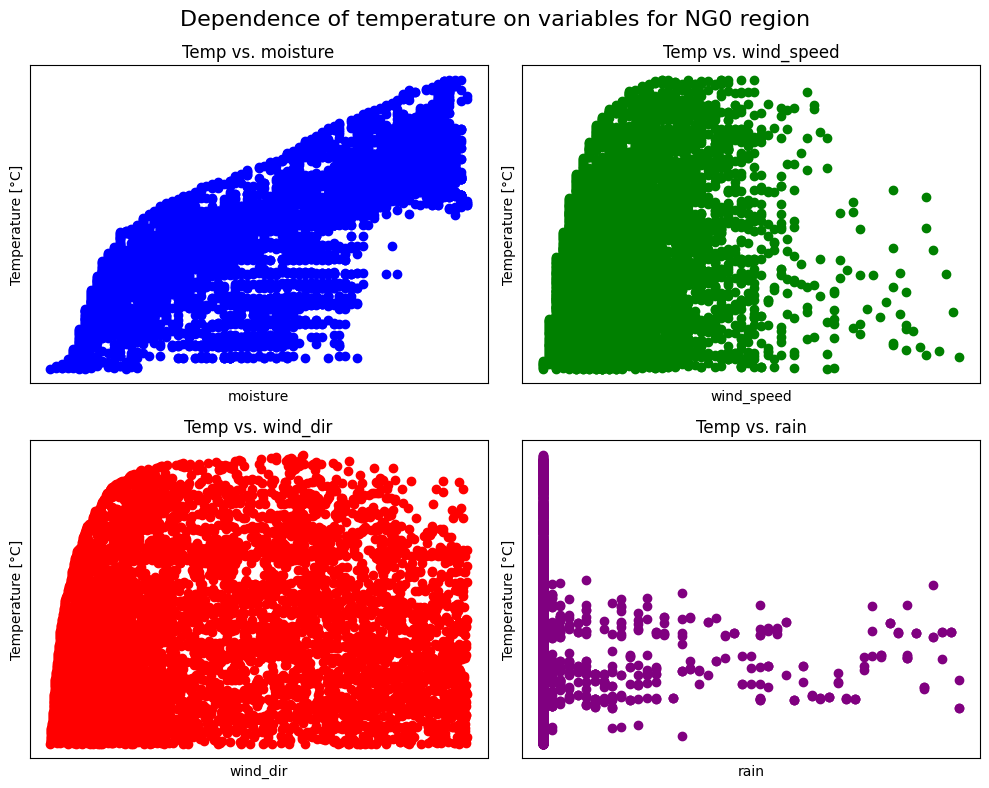

In [6]:
an.show_dependence(train_data, 'NG0')

The correlation between variables (as it is expected from the relationship plots) isn't the best either.

In [7]:
an.show_corr(train_data, 'NG0')

### ADDING FEATURES
The main features that appeared to make sense include one-hot encoding the temporal data, specifically the hour of the day, as it has a significant influence on the temperature. Additionally, we'll incorporate lagged features for humidity, which already shows a clear linear correlation with the temperature.

Let's start by defining some useful variables.


In [8]:
# the last day of training data
now = dt.datetime.now() - dt.timedelta(days = 2)
now = now.replace(hour=0, minute=0, second=0, microsecond=0)
# interval for the first day of training data
train_interval = dt.timedelta(days = 44)
#for past data (not made for leap years)
yearly_interval =  dt.timedelta(days = 365)
# interval for test data
test_interval = dt.timedelta(days = 2)
#lists of regions with 10 minute measurements and 30 minute measurements
short_regions = ['NG', 'LJ', 'MS', 'NM']
long_regions = ['PO', 'CE', 'JE']

At this point, it's important to mention that certain regions (namely Portorož, Celje, and Jesenice) have 30-minute measurement intervals, while others (Nova Gorica, Ljubljana, Murska Sobota, and Novo Mesto) have 10-minute intervals. As we proceed, we'll assess whether this difference significantly impacts our results.

Now let's add the features.

In [9]:
train_data = an.set_train_index(now,train_data, train_interval, yearly_interval, short_regions, long_regions)
test_data = an.set_test_index(test_data, short_regions, long_regions)
train_data, test_data = an.hot_encode(train_data, test_data)
train_data, test_data = an.create_lags(train_data, test_data,3, ["moisture"])

Here are the distinct dataframes for visual comparison.

In [10]:
train_data['NG0'].head(3)

,temp,moisture,rain,wind_speed,wind_dir,pressure,hour_0,hour_1,hour_2,hour_3,...,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,moisture_lag_1,moisture_lag_2,moisture_lag_3
2023-07-12 00:30:00,24.7,67,0,1.1,132,1.3,1,0,0,0,...,0,0,0,0,0,0,0,66,66,65
2023-07-12 00:40:00,24.6,68,0,0.4,109.6,0.7,1,0,0,0,...,0,0,0,0,0,0,0,67,66,66
2023-07-12 00:50:00,24.4,69,0,0.6,114.6,0.9,1,0,0,0,...,0,0,0,0,0,0,0,68,67,66


In [11]:
train_data['PO0'].head(3)

,temp,moisture,rain,wind_speed,wind_dir,pressure,hour_0,hour_1,hour_2,hour_3,...,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,moisture_lag_1,moisture_lag_2,moisture_lag_3
2023-07-12 01:30:00,23.6,72,0,0.7,46,1.8,0,1,0,0,...,0,0,0,0,0,0,0,70,70,73
2023-07-12 02:00:00,23.3,72,0,0.6,95,1.3,0,0,1,0,...,0,0,0,0,0,0,0,72,70,70
2023-07-12 02:30:00,23.2,76,0,1.1,337,2,0,0,1,0,...,0,0,0,0,0,0,0,72,72,70


### MODEL TRAINING
For model training, I employ `LinearRegression()` from the scikit-learn library.

**DISCLAIMER!**
Currently, I drop the pressure column from my data since I couldn't locate the data for certain regions (though I plan to incorporate it in the future).


In [12]:
for i in train_data:
    train_data[i] = train_data[i].drop(['pressure'], axis=1)

# Also rearange the test data columns to match train data
for i in test_data:
    test_data[i] = test_data[i][list(train_data[f'{i}0'])]
    test_data[i] = test_data[i].apply(pd.to_numeric)

all_models = an.train_models(train_data)

An interesting thing occurs at this point: the use of `pd.to_numeric` introduces some NaN values in the data. While I haven't identified the exact cause of this, I've addressed it by forward-filling the data (Since this happens rarely it should't have an effect on the models).

In [13]:
train_data, test_data = an.fill_na(train_data, test_data)

### MODEL TESTING
I evaluate the models using the Mean Squared Error (MSE). It's worth noting that the measurement frequency significantly influences the model's accuracy. Predictions for regions with 30-minute measurements exhibit lower accuracy compared to those with 10-minute measurements. I'm confident enough in the forecast's validity for regions with 10-minute measurements that I wouldn't hesitate to trust the predicted temperature if I were outside.

In [14]:
models = an.test_models(all_models, test_data)
mse = an.show_mse(all_models, test_data, ['NG', 'LJ', 'MS', 'NM', 'PO', 'CE', 'JE'])
mse

{'NG0': 7.710962568288142,
 'NG1': 6.43177987741843,
 'NG2': 4.317165093822852,
 'LJ0': 2.6119202902949135,
 'LJ1': 1.2823254150025916,
 'LJ2': 8.919756602103403,
 'MS0': 6.736069929413683,
 'MS1': 14.928043994383668,
 'MS2': 1.5751072970941902,
 'NM0': 4.913202125031879,
 'NM1': 10.732245267187748,
 'NM2': 3.3296640731665876,
 'PO0': 6.393338287690888,
 'PO1': 3.681737704414032,
 'PO2': 5.100952389616334,
 'CE0': 3.6386159368733844,
 'CE1': 8.681160856013177,
 'CE2': 4.97017951160838,
 'JE0': 6.976630605039549,
 'JE1': 2.5620340353643463,
 'JE2': 5.442178872851774}

The following graph shows a visual comparisson of MSE for each ragion.

In [15]:
an.mse_graph(mse, ['NG', 'LJ', 'MS', 'NM', 'PO', 'CE', 'JE'])

Although I don't use the R^2 coefficient to select my models, it's still interesting to showcase. Generally, the R^2 coefficient aligns with the MSE in terms of indicating the better model. We can clearly see which regins have 30 minute measurements.

In [16]:
r2 = an.show_r2(all_models, test_data, ['NG', 'LJ', 'MS', 'NM', 'PO', 'CE', 'JE'])
r2

{'NG0': 0.6924511403962907,
 'NG1': 0.7915343244045252,
 'NG2': 0.8149656715211895,
 'LJ0': 0.852689940186372,
 'LJ1': 0.9419458375915218,
 'LJ2': 0.14185147580691637,
 'MS0': 0.383155523343769,
 'MS1': -0.47955372261015206,
 'MS2': 0.9339868303494827,
 'NM0': 0.6767736552058362,
 'NM1': 0.16267952171029487,
 'NM2': 0.7934783545276279,
 'PO0': 0.4785519310954188,
 'PO1': 0.796488792685685,
 'PO2': 0.7136820564447213,
 'CE0': 0.7853573937389865,
 'CE1': 0.3515695899233974,
 'CE2': 0.6749404653721979,
 'JE0': 0.5724209326208969,
 'JE1': 0.9020925602061144,
 'JE2': 0.723532800159701}

For Nova Gorica the model's predictions and the actual temperatures look like this.

In [17]:
an.compare_region_models('NG', all_models, test_data)

At this points, it would be nice to provide actual predictions of future temperatures. However, I couldn't find freely available predictions of future measurements on ARSO. If I were to proceed with predictions despite this setback, I would have needed to opt for a different model type, likely a time series model such as ARIMA.

Luckily you can still see the temperature predictions for each ragion by changing the parameter in `an.compare_region_models`  you will just get the forecast for the last 48 hours. :)